# Download elevation model variables

Download elevation raster layer covering your study area envelope.
Consider **slope** or **aspect** to use in your model. 
Probably use the 
[xarray-spatial](https://xarray-spatial.readthedocs.io/en/stable/)
library, which is available in the latest `earth-analytics-python environment`
(but will need to be installed/updated if you are working on your own machine).
Note that calculated slope may not be correct if you are using a CRS with units of *degrees*;
re-project into a coordinate system with units of *meters*, such as the appropriate 
[UTM Zone](https://pypi.org/project/utm-zone/).

Specifically, `X,Y` are `lon,lat` in degrees, while `Z` (height) is in meters.
Need to reproject into UTM with meters, which meanes we have to find the UTM Zone.
Need to find our area. The
[UTM Zone Finder](https://mapscaping.com/utm-zone-finder)
shows that we are in `UTM Zone 13` (and actually `13N` north).
We need the projection (EPSG) for UTM zone 13N, which is `EPSG:32613` by looking at <https://epsg.io>.

- Elevation from the SRTM (available from the [earthaccess API](https://github.com/nsidc/earthaccess/))
- Elsa video
    - [Shuttle Radar Topology Mission (SRTM)](https://cuboulder.zoom.us/rec/play/6fTikKcJPbGPB321iHmAa3dhMUR7r0n_zSZ3XxjL-SfBLpVfsrZJ1CrHlkOrK6jvTlYgztvvskfvaAGP.T6ixGvWj42gYShMV?canPlayFromShare=true&from=share_recording_detail&continueMode=true&componentName=rec-play&originRequestUrl=https%3A%2F%2Fcuboulder.zoom.us%2Frec%2Fshare%2FploG3HVb_qA0QU8eACIHMKtNbkiGFys7cmiBbTRryv3NUWBmKo-DXhzXdU3cbpz7.99x0PeiCHONSj6Ty)

In [1]:
pip install --quiet ~/Documents/GitHub/landmapy

Note: you may need to restart the kernel to use updated packages.


In [10]:
from landmapy.habitat import create_data_dir, merge_soil, maca_year, process_maca
from landmapy.index import gdf_over_da

import rioxarray as rxr

More packages for slope and aspect

In [3]:
import earthaccess
import xrspatial
import rioxarray as rxr
import rioxarray.merge as rxrmerge

import os
from glob import glob

/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
data_dir = create_data_dir('habitat')
data_dir

'/Users/brianyandell/earth-analytics/data/habitat'

In [5]:
%store -r buffalo_gdf
#buffalo_gdf.plot()

In [6]:
buffalo_gdf

,OBJECTID,NATIONALGRASSLANDID,GRASSLANDNAME,GIS_ACRES,SHAPEAREA,SHAPELEN,geometry
12,185977,295518010328,Buffalo Gap National Grassland,654877.177,0.295196,33.006274,"MULTIPOLYGON (((-102.3384 43.93679, -102.33339..."
15,185980,295521010328,Oglala National Grassland,215804.927,0.096279,1.970612,"POLYGON ((-103.72478 43.001, -103.725 43.001, ..."


In [16]:
buffalo_gdf['color'] = ['white','red']

In [8]:
buffalo_gdf['color'].values[0]

'white'

## Slope and Aspect

In [6]:
project_dir = create_data_dir('habitat')
elevation_dir = create_data_dir('habitat/srtm')
elevation_dir

'/Users/brianyandell/earth-analytics/data/habitat/srtm'

In [10]:
earthaccess.login()

In [11]:
datasets = earthaccess.search_datasets(keyword='SRTM DEM', count=11)
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle']) # want 'umn'
# want SRTMGL1? 1 arc second = 30m (also, 3, 30 arc second)

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002


Note label as `hgt` and files are zipped.
Choice of opening or download. We will download

In [13]:
glob(os.path.join(elevation_dir, '*.hgt.zip'))

['/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W102.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W102.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W105.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W105.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W104.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W104.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W103.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W103.SRTMGL1.hgt.zip']

In [36]:
def srtm_download(place_gdf, elevation_dir, buffer = 0.1):
    """
    Download SRTM data and create DataArray.

    Parameters
    ----------
    place_gdf: GeoDataFrame
      GeoDataFrame for redlined city
    elevation_dir: character string
      Name of directory with elevation data
    buffer: number
      Buffer around bounds of place_gdf
    Results
    -------
    srtm_da: DataArray
      DataArray of SRTM stuff
    """
    import os
    import earthaccess
    from glob import glob
    import xrspatial
    import rioxarray as rxr
    import rioxarray.merge as rxrmerge
    from landmapy.habitat import da_bounds

    # Get bounds from gdf. (want to DRY by using part of da_bounds())
    bounds = place_gdf.total_bounds
    bounds = bounds + [x * buffer for x in [-1,-1,1,1]] # buffer around place_gdf
    bounds = tuple(bounds)

    # This gets list of granules. Only need to do once.
    srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')
    if(not glob(srtm_pattern)):
        earthaccess.login()
        srtm_results = earthaccess.search_data(
            short_name = 'SRTMGL1',
            bounding_box = bounds
        )
        srtm_results = earthaccess.download(srtm_results, elevation_dir)

    srtm_da_list = []
    for srtm_path in glob(srtm_pattern):
        tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
        tile_da = tile_da.rio.clip_box(*bounds)
        srtm_da_list.append(tile_da)

    srtm_da = rxrmerge.merge_arrays(srtm_da_list)
    # Make sure we are bounding properly.
    srtm_da = da_bounds(place_gdf, srtm_da, 0.1)

    return srtm_da

# srtm_da = srtm_download(place_gdf, elevation_dir, 0.1)
# srtm_da.plot(cmap='terrain')

def srtm_slope(srtm_da, UTM = 32613):
    """
    Calculate slope from SRTM data.

    Project to UTM to calculate slope, then project back.
    """
    import xrspatial
    import rioxarray as rxr

    orig_crs = srtm_da.rio.crs
    srtm_utm_da = srtm_da.rio.reproject(UTM)
    slope_da = xrspatial.slope(srtm_utm_da).rio.reproject(orig_crs)
    
    return slope_da

# slope_da = srtm_slope(srtm_da, 32613)

In [16]:
srtm_da = srtm_download(buffalo_gdf, elevation_dir, 0.1)

In [21]:
#srtm_da.plot()

In [22]:
buffalo_gdf['color'] = ['black','red']

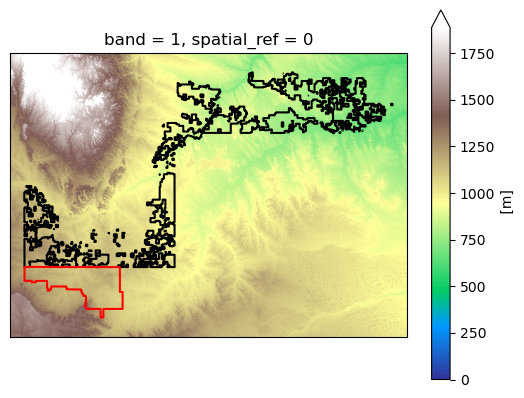

In [23]:
gdf_over_da(buffalo_gdf, srtm_da, cmap='terrain')

In [37]:
slope_da = srtm_slope(srtm_da)

In [40]:
#slope_da.plot(robust=True, cmap='terrain')

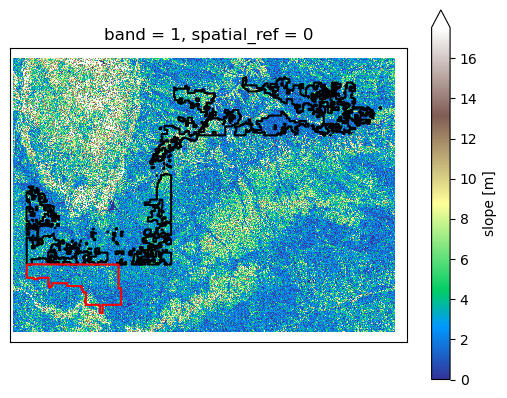

In [41]:
gdf_over_da(buffalo_gdf, slope_da, cmap='terrain')

Alternate plot only inside grasslands.

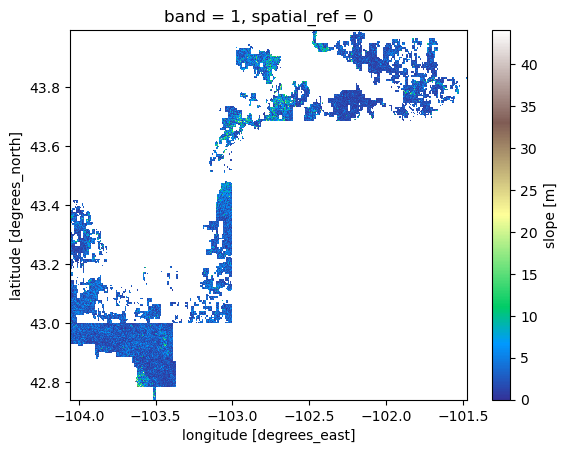

In [ ]:
import matplotlib.pyplot as plt # Overlay raster and vector data

slope_clip_da = slope_da.rio.clip(buffalo_gdf.geometry)
slope_clip_da.plot(cmap='terrain')
#buffalo_gdf.boundary.plot(ax=plt.gca(), color = "black", linewidth=0.5)
plt.show()